# import libraries 

In [0]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

2.2.0-rc3


# define the helper functions 

In [0]:
def plot_graphs(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('time')
  plt.ylabel('value')
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  """arbitrary pattern"""
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  """repeat pattern after each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  random = np.random.RandomState(seed)
  return random.randn(len(time)) * noise_level

def moving_average_forecast(series, window_size):
  # forecasts the mean of the last few values
  # if the window_size=1, then forecast = naive forecast
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

# define hyperparameters

In [0]:
time = np.arange(4 * 365 * 1,dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
split_time = 1000

# create series 
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# add noise 
series += noise(time, noise_level=noise_level, seed=42)

# visualize baseline series 

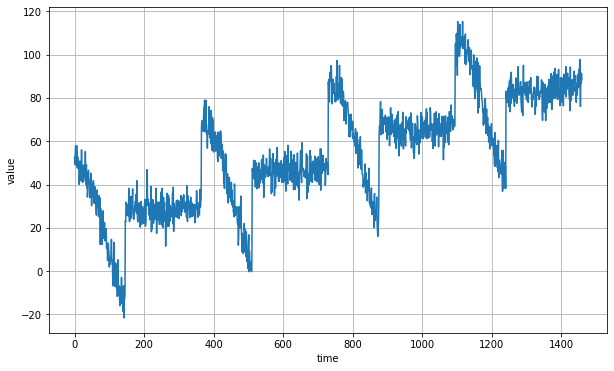

In [0]:
plt.figure(figsize=(10,6))
plot_graphs(time, series)

# split the timeseries dataset

into training & validation 

In [0]:
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]


visualize train & validation subsets

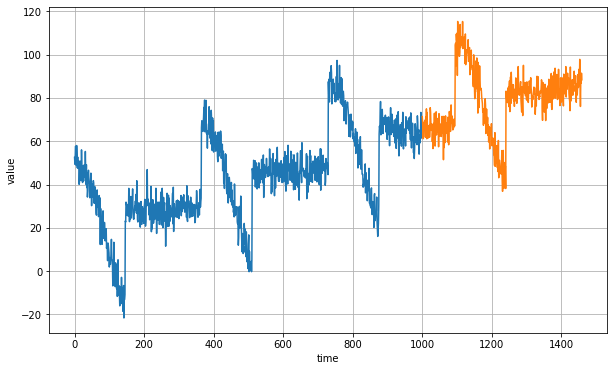

In [0]:
plt.figure(figsize=(10,6))
plot_graphs(time_train, x_train)
plot_graphs(time_valid, x_valid)


# naive forecasting

`The naive method of forecasting dictates that we use the previous period to forecast for the next period.`

Naïve forecasts are the most cost-effective forecasting model, and provide a benchmark against which more sophisticated models can be compared.
- This forecasting method is only suitable for time series data.

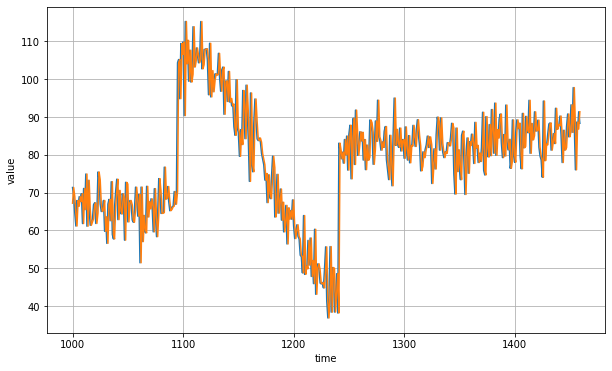

In [0]:
naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10,6))
plot_graphs(time_valid, x_valid)
plot_graphs(time_valid, naive_forecast)


# windowing

the window defines the number of raw observations by zooming in on a specific timeframe
- windowing is commonly used to calculate the moving average value.

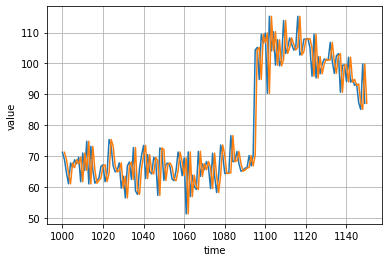

In [0]:
# comparing baseline vs (naive forecast window + 1)
plot_graphs(time_valid, x_valid, start=0, end=150)
plot_graphs(time_valid, naive_forecast, start=1, end=151)

# get loss

`convert into numpy since ML love that format` 

mse= mean squared error
- we square values to remove negative values

mae= mean absolute deviation/error
- we use absolute values and not penalize large errors as much

In [0]:
print('mse: {}'.format(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()))
print('mae: {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()))

mse: 59.4512825012207
mae: 5.876938819885254


# moving average forecast

`A moving average is a technique that calculates the overall trend in a data set.`

Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series.

A moving average requires that you specify a window size called the window width.
- This defines the number of raw observations used to calculate the moving average value.

**The “moving” part in the moving average refers to the fact that the window defined by the window width is slid along the time series to calculate the average values in the new series.**

---

This technique is very useful for forecasting short-term trends.
-  *example:*
  - in operations management, the data set is sales volume from historical data of the company. 

mse: 104.1346206665039
mae: 7.080320358276367


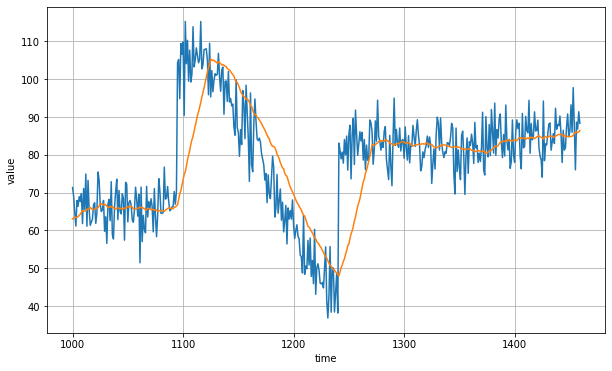

In [0]:
# [split_time - 30:] after function= extract the items in range [start:end] in the list/tuple returned by the function.
moving_avg = moving_average_forecast(series, window_size=30)[split_time - 30:]

plt.figure(figsize=(10,6))
plot_graphs(time_valid, x_valid)
plot_graphs(time_valid, moving_avg)

# mse= square values to remove negative values
print('mse: {}'.format(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()))
# mae= use absolute values and not penalize large errors as much
print('mae: {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()))

# differences

`to make a NON-STATIONARY time series STATIONARY by computing the differences between consecutive observations.`

differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

---

a non-stationary series is one whose statistical properties change over time.

a stationary time series is one whose statistical properties such as the mean, variance and autocorrelation are all constant over time.


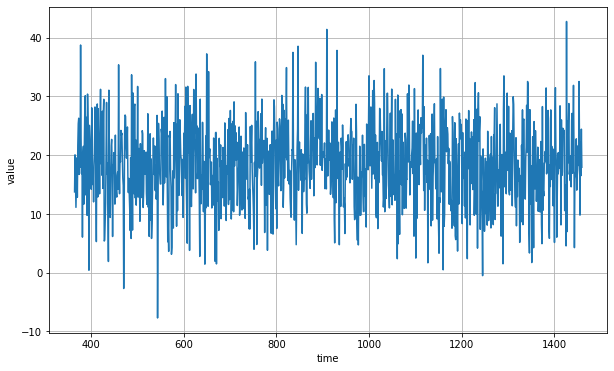

In [0]:
# remove trend & seasonality using differences since the moving_avg does not anticipate them: causing inferior performance
# since the seasonality period is 365 days, we subtract 365 from the value at time t
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_graphs(diff_time, diff_series)

# stationary time series

`a time series whose properties do not depend on the time at which the series is observed.`

- white noise series IS stationary: 
  - it does not matter when you observe it, it should look much the same at any point in time.

`time series with trends, or with seasonality, are NOT stationary: the trend and seasonality will affect the value of the time series at different times.`


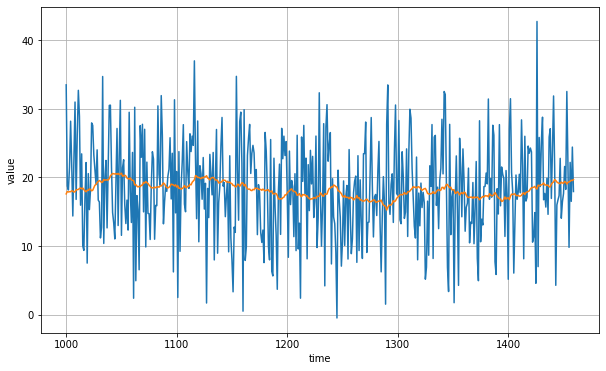

In [0]:
# since we have removed trend & seasonality, we can use the (now stationary) moving avg
# [split_time - 365 - 50:] after function= extract the items in range [start:end] in the list/tuple returned by the function.
diff_moving_average = moving_average_forecast(diff_series, window_size=50)[split_time - 365 - 50:]

plt.figure(figsize=(10,6))
plot_graphs(time_valid, diff_series[split_time - 365:])
plot_graphs(time_valid, diff_moving_average)

# seasonal differencing 

`A seasonal difference is the difference between an observation and the previous observation from the same season.`

---

It is important that if differencing is used, the differences are interpretable.
- First differences are the change between one observation and the next.
- Seasonal differences are the change between one year to the next. 

Other lags are unlikely to make much interpretable sense and should be avoided.

mse: 53.082298278808594
mae: 5.848239898681641


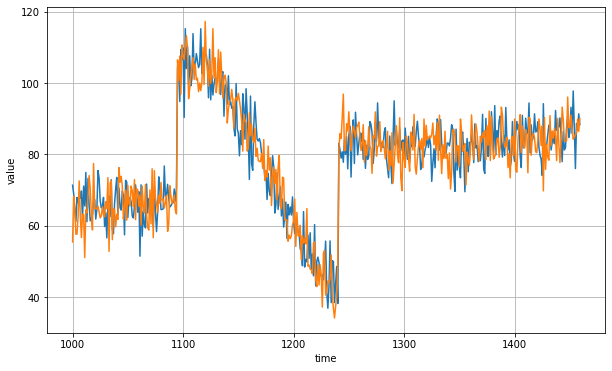

In [0]:
# add back trend & seasonality
diff_moving_avg_plus_past = series[split_time-365:-365] + diff_moving_average

plt.figure(figsize=(10,6))
plot_graphs(time_valid, x_valid)
plot_graphs(time_valid, diff_moving_avg_plus_past)

# mse= square values to remove negative values
print('mse: {}'.format(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy()))
# mae= use absolute values and not penalize large errors as much
print('mae: {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()))

# smoothing 

`Smoothing is a technique applied to time series  to remove noise and better expose the signal of the underlying causal processes.`

--- 

**Moving averages** are a simple and common type of **SMOOTHING** used in time series analysis and time series forecasting.

Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series.

- window size= the number of raw observations used to calculate the moving average value.

- moving= the window width is slid along the time series to calculate the average values in the new series.

mse: 32.92927169799805
mae: 4.543388366699219


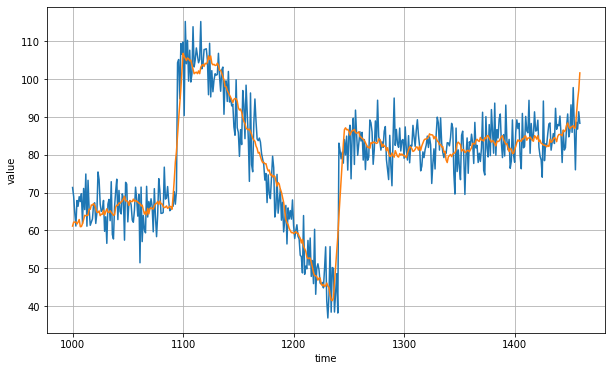

In [0]:
# use moving avg to remove noise
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], window_size=10) + diff_moving_average

plt.figure(figsize=(10,6))
plot_graphs(time_valid, x_valid)
plot_graphs(time_valid, diff_moving_avg_plus_smooth_past)


# mse= square values to remove negative values
print('mse: {}'.format(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()))
# mae= use absolute values and not penalize large errors as much
print('mae: {}'.format(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()))

# clean up

terminate memory kernel and free up resources

In [0]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)